In [343]:
### Solve Heat Equation

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.testing as nptest
import scipy.sparse as sparse
import scipy.sparse.linalg as sparselinalg

In [326]:
# we are trying to solve problem for which u(x,y) = x**4*y**5-17*sin(xy) is a solution

In [327]:
def u(x,y): return x**4*y**5-17*np.sin(x*y)

In [328]:
#RHS
def f(x,y): return 12*x**2*y**5+20*x**4*y**3+(x**2+y**2)*17*np.sin(x*y)

In [329]:
# our Omega is (0,1)x(0,1)
###generate RHS f, order nodes lexicographically
# determine pointwise values for u



In [330]:
#generate mesh, i.e. x_i,y_i (including the boundary)
# our n ranges from 2 to 8, i.e. if n=2, we have h_x=h_y=1/4
# if h=2**(-n), then there are 2**n+1 grid points in each direction

def meshvector(n):
    h=2**(-n)
    pts=2**n-1
    x=np.zeros(((2**n-1)**2,2))
    # print(len(x))
    for j in range(pts):
        for i in range(pts):
            x[pts*j+i,0]=(i+1)*2**(-n)
            x[pts*j+i,1]=(j+1)*2**(-n)
            # print((i,j))
            # print(x[n*j+i,:])
    return x

In [331]:
meshvector(2)

array([[ 0.25,  0.25],
       [ 0.5 ,  0.25],
       [ 0.75,  0.25],
       [ 0.25,  0.5 ],
       [ 0.5 ,  0.5 ],
       [ 0.75,  0.5 ],
       [ 0.25,  0.75],
       [ 0.5 ,  0.75],
       [ 0.75,  0.75]])

In [344]:
# determine values for f on mesh

def f_on_mesh(x,n):
    if(n==1):
        print("error, n too small")
    h=2**(-n)
    len_x=len(x)
    f_mesh = np.zeros(len_x)
    for i in range(len_x):
        print("index", i)
        f_mesh[i]=f(x[i,0],x[i,1])
        if(i<2**n-1):
            f_mesh[i]+=u(x[i,0],x[i,1]-h)/h**2
            print(1)
        if(i>=(2**n-1)*(2**n-2)):
            f_mesh[i]+=u(x[i,0],x[i,1]+h)/h**2
            print(2)
        if((i % (2**n-1))==(2**n-2)):
            f_mesh[i]+=u(x[i,0]+h,x[i,1])/h**2
            print(3)
        if((i % (2**n-1))==0):
            f_mesh[i]+=u(x[i,0]-h,x[i,1])/h**2
            # print(i % (2**n-1))
            print(4)
            # print(x[i,:])
            # print(f_mesh[i])
    return f_mesh        

In [346]:
x = meshvector(2)
f_on_mesh(x,2)

index 0
1
4
index 1
1
index 2
1
3
index 3
4
index 4
index 5
3
index 6
2
4
index 7
2
index 8
2
3


array([  1.34679175e-01,   6.84795459e-01,  -6.51922481e+01,
         6.95537646e-01,   2.35293365e+00,  -1.23842654e+02,
        -6.50399044e+01,  -1.23105349e+02,  -3.47481212e+02])

In [334]:
#Testing RHS

n=4
N=2**n+1
x = meshvector(n)
print(len(x))
f_m=f_on_inner_mesh(x,n)
f_m.reshape((N,N))

nptest.assert_almost_equal(f_m[-1], 1-17*np.sin(1)) #last entry
nptest.assert_almost_equal(f_m[:N],[0]*N) #first line is zero
nptest.assert_almost_equal(f_m[:N:],[0]*N) #y = 0

225


ValueError: total size of new array must be unchanged

In [335]:
# generating B part of A

def BpartA(n):
    h=1/2**n
    N=2**n-1
    data=[[-1/h**2]*(N)**2, [4/h**2]*(N)**2, [-1/h**2]*(N)**2]
    offsets = np.array([-1,0,1])
    b = sparse.dia_matrix((data, offsets),shape=(N,N)).toarray() 
    bmultiple = (b,)*(N)
    return sparse.block_diag(bmultiple).toarray()

In [336]:
BpartA(2)

array([[ 64., -16.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [-16.,  64., -16.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., -16.,  64.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  64., -16.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., -16.,  64., -16.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., -16.,  64.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  64., -16.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., -16.,  64., -16.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., -16.,  64.]])

In [337]:
def CpartA(n):
    h=1/2**n
    N=2**n-1
    cdata=[[-1/h**2]*(N)**2,[-1/h**2]*(N)**2]
    offset=np.array([N,-N])
    return sparse.dia_matrix((cdata, offset),shape=((N)*(N),(N)*(N))).toarray()

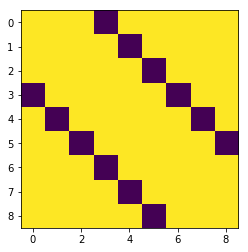

In [338]:
c=CpartA(2)
plt.imshow(c, interpolation='none')

In [339]:
def generateA(n):
    A=BpartA(n)+CpartA(n)
    print(A.shape)
    return A

(49, 49)


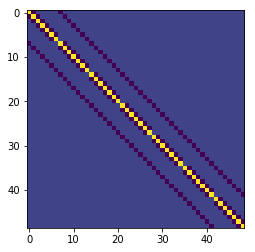

In [340]:
a=generateA(3)
plt.imshow(a, interpolation='none')

In [341]:
x=meshvector(2)
f_on_mesh(x,2)
generateA(2)
sparselinalg.spsolve(generateA(2), f_on_mesh(meshvector(2),2))
np.linalg.solve(generateA(2),f_on_mesh(meshvector(2),2))

(9, 9)
(9, 9)
(9, 9)


C:\Users\Lisa\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:101: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


array([-0.93845559, -1.88196131, -2.90329709, -1.88027848, -3.72889228,
       -5.65671153, -2.89723717, -5.64367616, -8.25449087])

In [342]:
n=2
x=meshvector(n)
u_real=np.zeros(len(x))
for i in range(len(x)):
    u_real[i]=u(x[i,0],x[i,1])
u_approx=sparselinalg.spsolve(generateA(n), f_on_mesh(x,n))
print(u(0.5,0.5))
print(u_real)
print(u_approx)
u_real-u_approx

(9, 9)
-4.20391418233
[-1.06180459 -2.11940943 -3.16854705 -2.1193484  -4.20391418 -6.2167453
 -3.16792907 -6.21180145 -8.99106076]
[-0.93845559 -1.88196131 -2.90329709 -1.88027848 -3.72889228 -5.65671153
 -2.89723717 -5.64367616 -8.25449087]


C:\Users\Lisa\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:101: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


array([-0.123349  , -0.23744812, -0.26524997, -0.23906991, -0.4750219 ,
       -0.56003377, -0.27069191, -0.56812529, -0.7365699 ])